# Example TokaMaker Equilibrium for ARC V2D

In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import CubicSpline
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

In [2]:
sys.path.append('/Applications/OpenFUSIONToolkit/python')
# tokamaker_python_path = os.getenv('OFT_ROOTPATH')
# if tokamaker_python_path is not None:
#     sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk

## Load reference eqdsk

In [3]:
eq = read_eqdsk('geqdsk-FreeGS-ARC-v2e-20250105.txt')

## Setup solver

### Initialize TokaMaker object
First we create a TokaMaker instance to use for equilibrium calculations. Note at present only a single instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [4]:
mygs = TokaMaker()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          2c5f6aa
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Load mesh into TokaMaker

In [5]:
meshname = 'meshes/arc_mesh_midplanegap'

mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh(meshname)
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)

mygs.setup_regions(cond_dict=cond_dict, coil_dict=coil_dict)
mygs.settings.maxits = 200
#mygs.settings.lim_zmax = 1.75
mygs.setup(order=2, F0=eq['rcentr']*eq['bcentr'])


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  1.100E+02
    # of points  =   13112
    # of edges   =   39193
    # of cells   =   26082
    # of boundary points =     140
    # of boundary edges  =     140
    # of boundary cells  =     140
  Resolution statistics:
    hmin =  7.702E-03
    hrms =  1.062E-01
    hmax =  4.439E-01
  Surface grounded at vertex    2235


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    1.0234999999999999E-002


### Define a vertical stability coil

In [6]:
vsc = 'PF5'
vsc_signs = np.zeros((mygs.ncoils,), dtype=np.float64)
vsc_signs[[mygs.coil_sets[f'{vsc}U']['id'], mygs.coil_sets[f'{vsc}L']['id']]] = [1.0,-1.0]
mygs.set_coil_vsc(vsc_signs)

### Define hard limits on coil currents
Hard limits on coil currents can be set using `set_coil_bounds`, which are then used in the shape fitting below.

Note that the size of the bounds array is (ncoils+1,2) as bounds can also be set for the VSC set, which is treated as a separate degree of freedom (virtual coil) if defined.

In [7]:
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds[:,0] = -5.5E7; coil_bounds[:,1] = 5.5E7
#coil_bounds[1:,:] /= 2
#print(coil_bounds)
mygs.set_coil_bounds(coil_bounds)

## Set global targets

In [8]:
pax_target = eq['pres'][0]
Ip_target = abs(eq['ip'])
mygs.set_targets(Ip=Ip_target,pax=pax_target)
#mygs.set_targets(Ip=Ip_target,Ip_ratio=0.48)

### Define shape targets
In order to constrain the shape of the plasma we can utilize two types of constraints:
 1. `isoflux` points, which are points we want to lie on the same flux surface (eg. the LCFS)
 2. `saddle` points, where we want the poloidal magnetic field to vanish (eg. X-points). While one can also use this constraint to enforce a magnetic axis location, instead `set_targets` should be used with arguments `R0` and `V0`.

**Note:** These constraints can be considered "soft" constraints, where the calculation attempts to minimize error in satisfying these constraints subject to other constraints and regularization.

Here we define a handful of isoflux points that we want to lie on the LCFS of the target equilibrium. Additionally, we define two X-points and set them as saddle constraints as well as add them to the list of isoflux points.

In [9]:
kappa = 1.75
delta = 0.6
squar = -0.05
a0 = 1.19
r0 = 4.57
z0 = 0

def update_boundary(r0, z0, a0, kappa, delta, squar, npts=20):
    thp = np.linspace(0,2*np.pi,npts+1)
    thp = thp[:-1]

    ra = r0 + a0*np.cos(thp + delta*np.sin(thp) - squar*np.sin(2*thp))
    za = z0 + kappa*a0*np.sin(thp + squar*np.sin(2*thp))
    return np.vstack([ra, za]).transpose()

boundary = update_boundary(r0, z0, a0, kappa, delta, squar)
boundary_weights = np.ones(len(boundary[:,0]))

x_points = np.array([[3.75, 2.15], [3.75, -2.15], [4.8, 3.7], [4.8, -3.7]])
x_weights = np.ones(len(x_points)) 

mygs.set_saddles(x_points, 2*x_weights)
mygs.set_isoflux(boundary, 10*boundary_weights)

# isoflux_pts = eq['rzout'].copy()[::3]
# mygs.set_isoflux(isoflux_pts, np.ones(len(isoflux_pts))*10)

### Define coil regularization matrix
In general, for a given coil set a given plasma shape cannot be exactly reproduced, which generally yields large amplitude coil currents if no constraint on the coil currents is applied. As a result, it is useful to include regularization terms for the coils to balance minimization of the shape error with the amplitude of current in the free coils. In TokaMaker these regularization terms have the general form of a vector of targets (often zero), a regularization matrix that maps the coil currents to the targets, and a vector of weights that can be used to control the relative impact of each term in the minimization.

Here we define three types of regularization targets:
 1. Targets that act to penalize up-down assymetry in U/L coil pairs
 2. A target to enforce the fixed relationship between CS1LI and CS1LO (also enforces this for the upper coil through other target types)
 3. Targets the act to penalize the amplitude of current in each coil

In the later case this regularization acts to penalize the amplitude of current in each coil, acting to balance coil current with error in the shape targets. Additionally, this target is also used to "disable" several coils by setting the weight on their targets high to strongly penalize non-zero current. Note that the VSC set is disabled to prevent up-down symmetric current in these coils. The actual up-down asymmetric current will be provided by the dedicated VSC virtual coil.

In [10]:
# from freegs solution
target_currents = -np.array([
    22e6,#43e6,#
    22e6,#43e6,#
    -6e6,
    -6e6,
    -22e6,#-20.69e6,#
    -22e6,#-20.69e6,#
    -12e6,
    -12e6,
    -14.17e6,#0.73e6,#
    -14.17e6,#0.73e6,#
    -4.97e6,#-6.62e6,#
    -4.97e6,#-6.62e6,#
    6.93e6,#10.36e6,#
    6.93e6,#10.36e6,#
    1.85e6,#0.25e6,#
    1.85e6,#0.25e6,#
    ])

coil_regmat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
coil_targets = np.zeros((mygs.ncoils+1,), dtype=np.float64)
coil_reg_weights = np.zeros((mygs.ncoils+1,), dtype=np.float64)
disable_list = ()
for name, coil in mygs.coil_sets.items():
    if name.find('U') >= 0: # Set regularization to enforce up-down symmetry
        coil_regmat[coil['id'],coil['id']] = 1.0
        coil_regmat[mygs.coil_sets[name.replace('U','L')]['id'],coil['id'],] = -1.0
        coil_reg_weights[coil['id']] = 1
    else: # Normal regularization
        coil_regmat[coil['id'],coil['id']] = 1.0
        if name[:3] in disable_list:
            coil_reg_weights[coil['id']] = 1.E4
        else:
            coil_reg_weights[coil['id']] = 1.E4#10

    if name.find('U') >= 0: # Targets on upper coils only, since symmetry is enforced
        coil_targets[coil['id']] = target_currents[coil['id']]

# Terms for VSC coil
coil_regmat[-1,-1] = 1.0
coil_reg_weights[-1] = 1.E-4

mygs.set_coil_reg(coil_regmat, reg_targets=coil_targets, reg_weights=coil_reg_weights)

### Define flux functions
Although TokaMaker has a "default" profile for the F\*F' and P' terms this should almost never be used and one should instead choose an appropriate flux function for their application. In this case we use a simple cubic flux function with the same shape for both F\*F' and P'. Within TokaMaker this profile is represented as a piecewise linear function, which can be set up using the dictionary approach shown below.

*More tools to aide in setting these profiles are coming soon*. For example, Daniel already has a working H-mode pedestal profile with self-consistent bootstrap that we will merge in shortly.

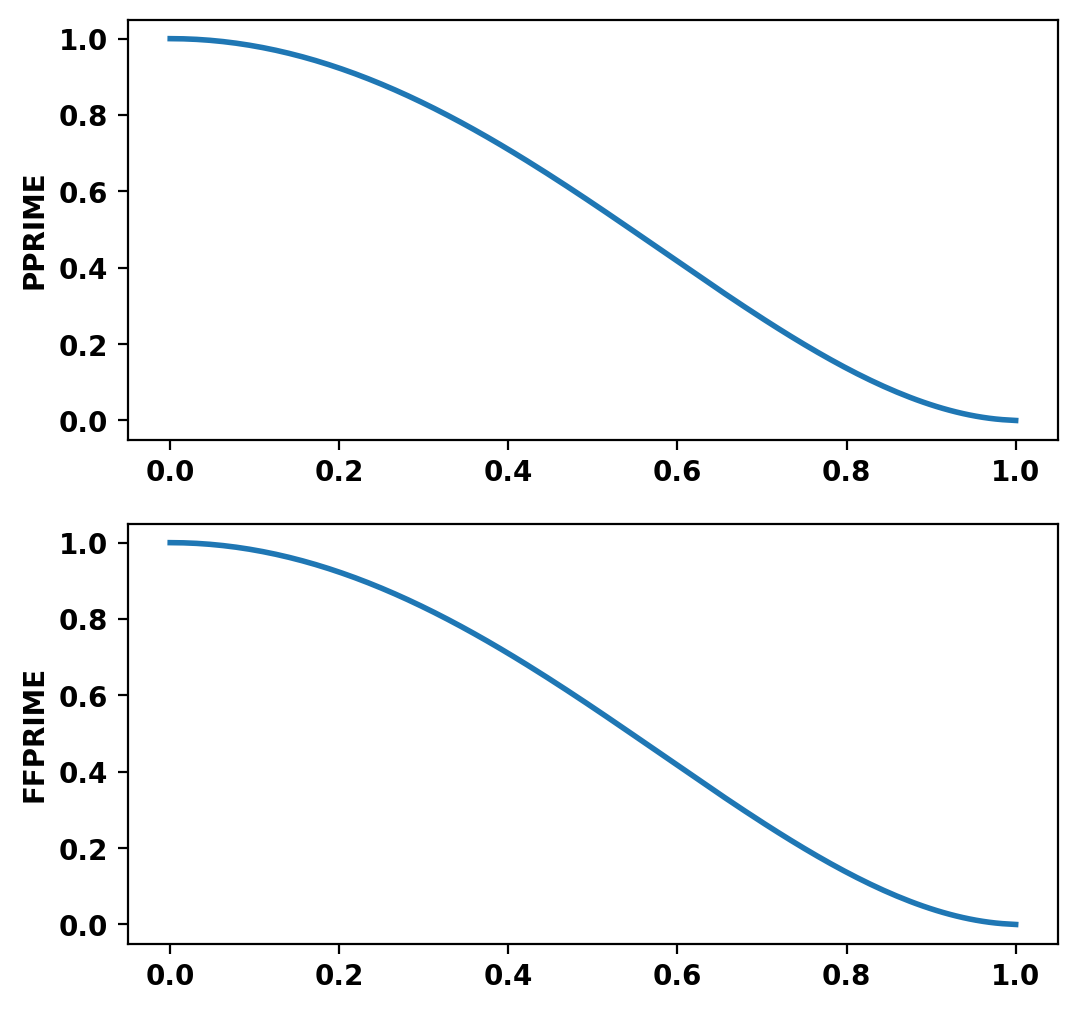

In [11]:
psi_eqdsk = np.linspace(0.0,1.0,eq['nr'])
# Create new F*F' profile
ffp_prof = {'type': 'linterp', 'x': psi_eqdsk, 'y': np.interp(psi_eqdsk,psi_eqdsk,eq['ffprim'])}
ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
ffp_prof['y'][-1] = 0.0 # Set edge to zero
# Create new P' profile
pp_prof = {'type': 'linterp', 'x': psi_eqdsk, 'y': np.interp(psi_eqdsk,psi_eqdsk,eq['pprime'])}
pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)
pp_prof['y'][-1] = 0.0 # Set edge to zero
# Update profiles in TokaMaker
mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

# Make figure
plt.figure()
plt.subplot(211)
plt.plot(pp_prof['x'], pp_prof['y'])
plt.ylabel('PPRIME')
plt.subplot(212)
plt.plot(ffp_prof['x'], ffp_prof['y'])
plt.ylabel('FFPRIME')
plt.show()

### Set resistivity profile from transport run

### Initialize equilibrium calculation
We can now compute a free-boundary equilibrium using these constraints. Note that before running a calculation for the first time we must initialize the flux function $\psi$, which can be done using `init_psi`. This subroutine initializes the flux using the specified Ip_target from above, which is evenly distributed over the entire plasma region or only with a boundary defined using a center point (R,Z), minor radius (a), and elongation and triangularity. Coil currents are also initialized at this point using the constraints above and this uniform plasma current initialization. 

We plot the solution and coil currents after initialization but _before_ the Grad-Shafranov solve for reference.


Coil Currents [MA-Turns]:
  CS1U:          -15.61 ( -55.00) [ 28.38%]
  CS1L:          -15.61 ( -55.00) [ 28.38%]
  CS2U:            6.93 (  55.00) [ 12.59%]
  CS2L:            6.93 (  55.00) [ 12.59%]
  CS3U:           20.26 (  55.00) [ 36.84%]
  CS3L:           20.26 (  55.00) [ 36.84%]
  PF1U:            8.02 (  55.00) [ 14.57%]
  PF1L:            8.02 (  55.00) [ 14.57%]
  PF2U:            6.66 (  55.00) [ 12.11%]
  PF2L:            6.66 (  55.00) [ 12.11%]
  PF3U:            0.05 (  55.00) [  0.08%]
  PF3L:            0.05 (  55.00) [  0.08%]
  PF4U:           -4.52 ( -55.00) [  8.22%]
  PF4L:           -4.52 ( -55.00) [  8.22%]
  PF5U:           -0.02 ( -55.00) [  0.03%]
  PF5L:           -0.02 ( -55.00) [  0.03%]


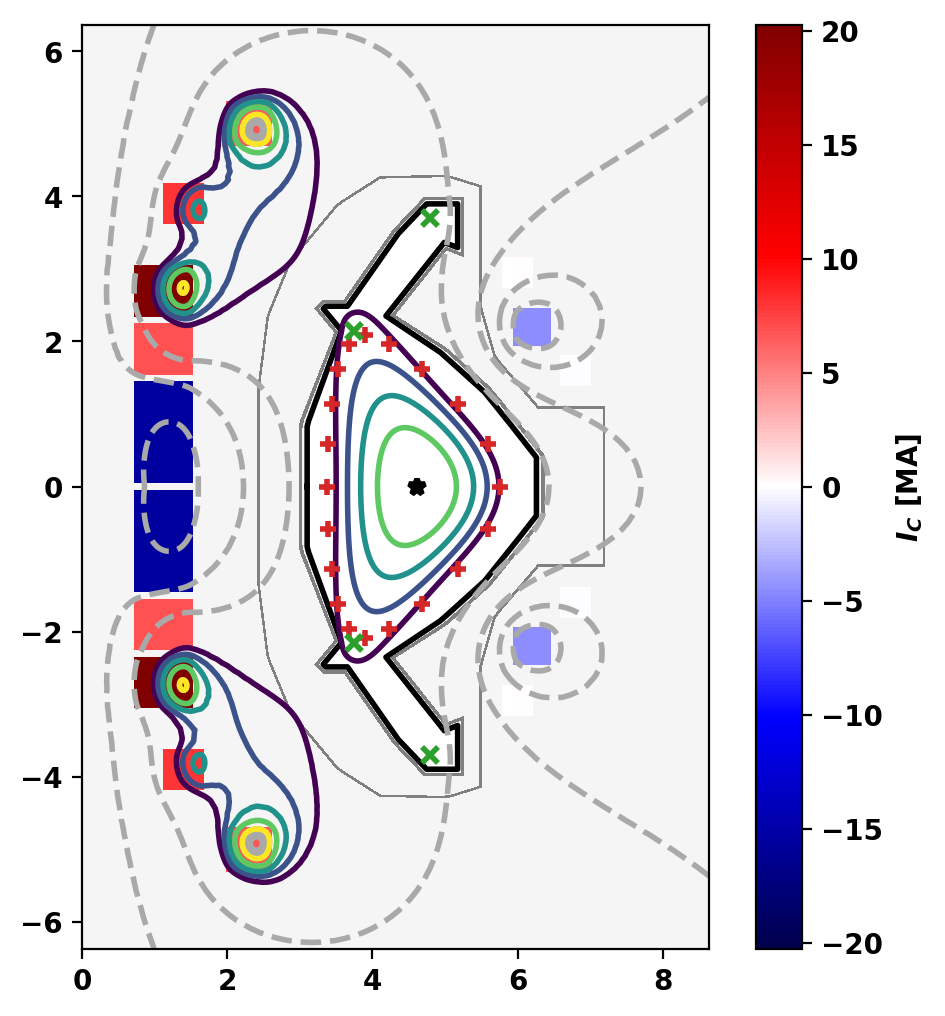

In [12]:
### Initialize equilibrium calculation
mygs.init_psi(r0=r0,z0=z0,a=a0/2,kappa=kappa/1.2,delta=delta)
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]',coil_symmap=True)
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_constraints(fig, ax)
# Print initial coil currents
print()
print("Coil Currents [MA-Turns]:")
coil_currents, _ = mygs.get_coil_currents()
for key in mygs.coil_sets:
    i = mygs.coil_sets[key]['id']
    if coil_currents[i] >= 0.0:
        proximity = coil_currents[i]*100/coil_bounds[i,1]
        near_limit = coil_bounds[i,1]
    else:
        proximity = coil_currents[i]*100/coil_bounds[i,0]
        near_limit = coil_bounds[i,0]
    print('  {0:10} {1:10.2F} ({2:7.2F}) [{3:6.2F}%]'.format(key+":",coil_currents[i]/1.E6,near_limit/1.E6,proximity))
    
plt.show()

### Solve the equilibrium

`solve` is then called to compute a self-consitent Grad-Shafranov equilibrium. If the result variable (`err_flag`) is zero then the solution has converged to the desired tolerance ($10^{-6}$ by default).

In [13]:
err_flag = mygs.solve()
psi0 = mygs.get_psi(normalized=False)
print(err_flag)

Starting non-linear GS solver
     1 -3.8355E+01  2.0079E+00  1.4482E-01  4.7221E+00  1.2139E-04 -2.4804E+02
     2  1.8734E+01  7.3208E-01  5.7909E-02  4.6652E+00 -1.7856E-04 -1.3707E+02
     3  2.3257E+01  6.3224E-01  2.2983E-02  4.6368E+00 -7.2793E-05 -9.8320E+01
     4  2.4197E+01  6.1068E-01  1.0177E-02  4.6231E+00  1.5353E-05 -8.5943E+01
     5  2.4396E+01  6.0534E-01  4.8281E-03  4.6164E+00  3.0405E-05 -7.9003E+01
     6  2.4414E+01  6.0404E-01  2.3611E-03  4.6131E+00  2.7576E-05 -7.2752E+01
     7  2.4391E+01  6.0383E-01  1.1693E-03  4.6114E+00  2.6178E-05 -6.9066E+01
     8  2.4365E+01  6.0389E-01  5.8254E-04  4.6106E+00  2.5423E-05 -6.6334E+01
     9  2.4345E+01  6.0401E-01  2.9131E-04  4.6102E+00  2.5038E-05 -6.4473E+01
    10  2.4331E+01  6.0410E-01  1.4618E-04  4.6100E+00  2.4830E-05 -6.3170E+01
    11  2.4322E+01  6.0417E-01  7.3650E-05  4.6099E+00  2.4715E-05 -6.2256E+01
    12  2.4316E+01  6.0422E-01  3.7282E-05  4.6099E+00  2.4649E-05 -6.1607E+01
    13  2.4313E+01  6.

### Print equilibrium information and coil currents
Basic parameters can be displayed using the `print_info` method. For access to these quantities as variables instead the `get_stats` can be used.

The final coil currents can also be retrieved using the `get_coil_currents` method, which are all within the approximate coil limits imposed above.

Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    1.2100E+07
  Current Centroid [m]    =    4.519 -0.000
  Magnetic Axis [m]       =    4.610  0.000
  Elongation              =    1.775 (U:  1.856, L:  1.694)
  Triangularity           =    0.549 (U:  0.610, L:  0.488)
  Plasma Volume [m^3]     =   193.243
  q_0, q_95               =   -0.906 -3.339
  Peak Pressure [Pa]      =    2.2211E+06
  Stored Energy [J]       =    1.4595E+08
  <Beta_pol> [%]          =   55.1403
  Diamagnetic flux [Wb]   =   -3.6653E-01
  Toroidal flux [Wb]      =   -8.4038E+01
  l_i                     =    1.1991

Coil Currents [MA-Turns]:
  CS1U:          -22.18 ( -55.00) [ 40.32%]
  CS1L:          -22.18 ( -55.00) [ 40.32%]
  CS2U:            6.46 (  55.00) [ 11.75%]
  CS2L:            6.46 (  55.00) [ 11.75%]
  CS3U:           22.39 (  55.00) [ 40.71%]
  CS3L:           22.39 (  55.00) [ 40.71%]
  PF1U:           12.00 (  55.00) [ 21.82%]
  PF1L:           12.00 ( 

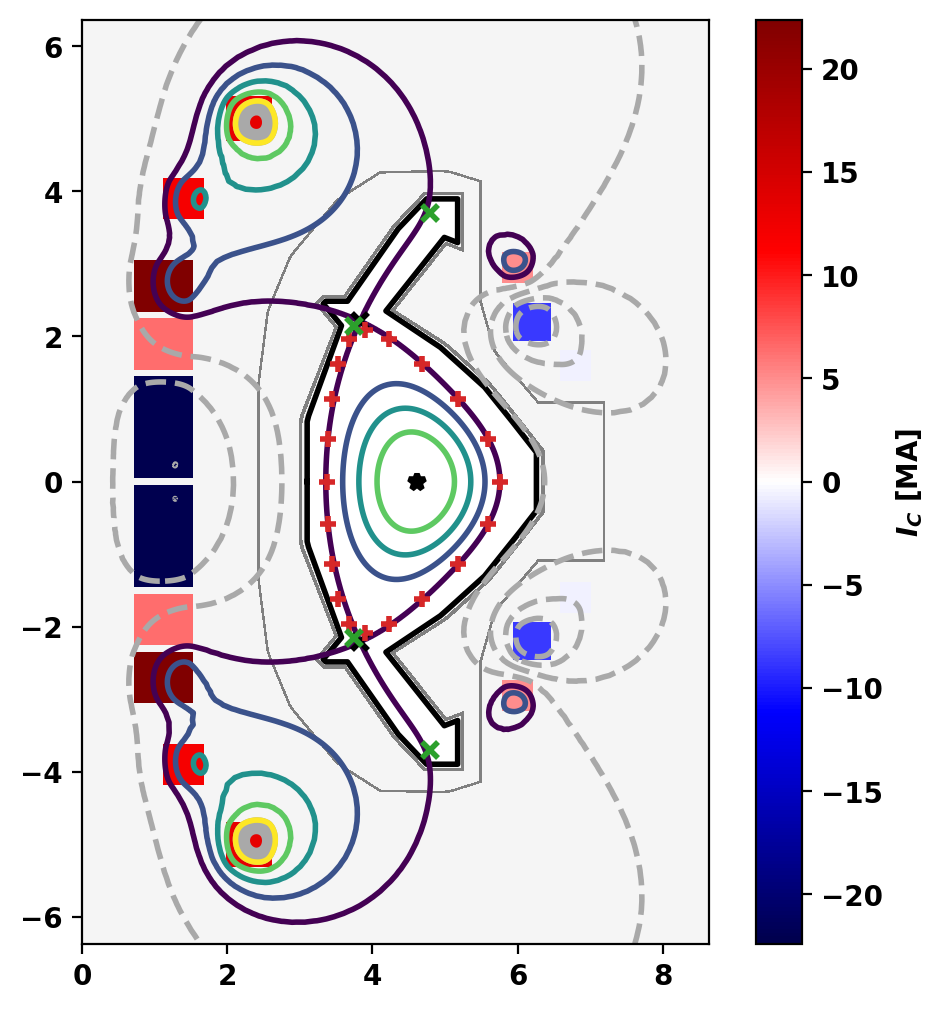

In [14]:
### Print equilibrium information and coil currents

mygs.print_info()
# Plot first case surfaces
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]',coil_symmap=True)
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_constraints(fig, ax)
# Print final coil currents
print()
print("Coil Currents [MA-Turns]:")
coil_currents, _ = mygs.get_coil_currents()
for key in mygs.coil_sets:
    i = mygs.coil_sets[key]['id']
    if coil_currents[i] >= 0.0:
        proximity = coil_currents[i]*100/coil_bounds[i,1]
        near_limit = coil_bounds[i,1]
    else:
        proximity = coil_currents[i]*100/coil_bounds[i,0]
        near_limit = coil_bounds[i,0]
    print('  {0:10} {1:10.2F} ({2:7.2F}) [{3:6.2F}%]'.format(key+":",coil_currents[i]/1.E6,near_limit/1.E6,proximity))
    
plt.show()
    

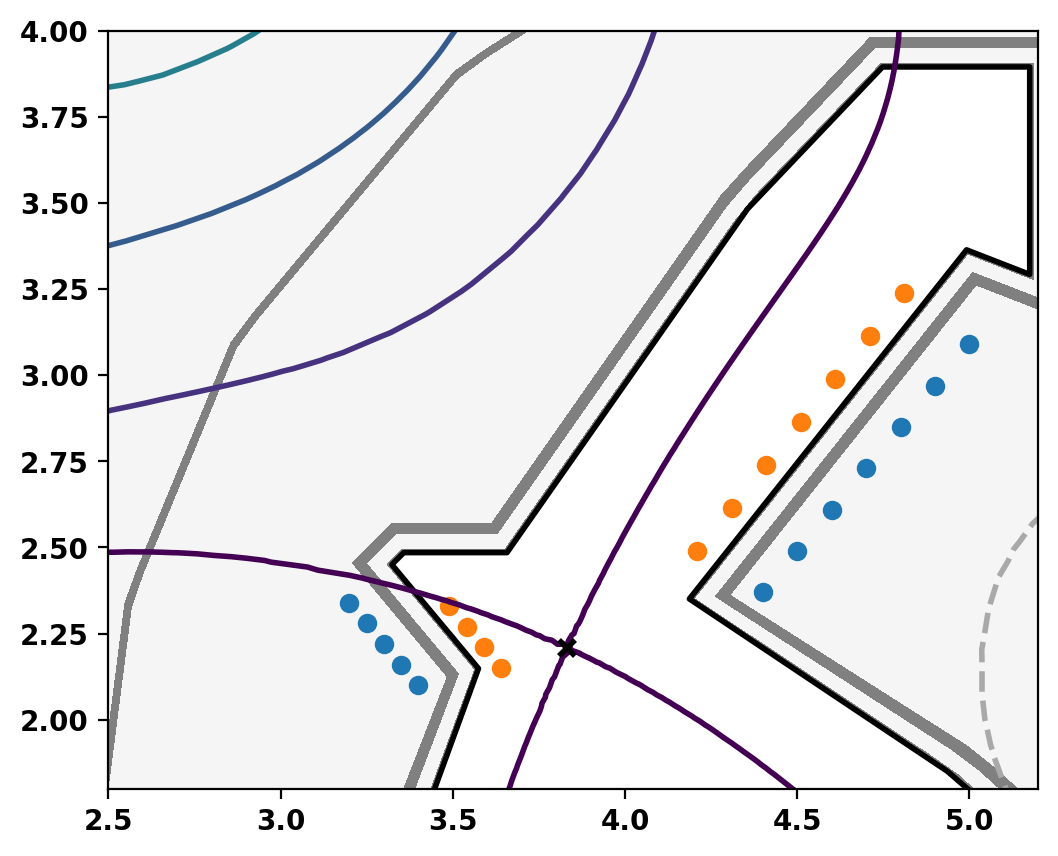

In [15]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax)
mygs.plot_psi(fig,ax)
ax.set_xlim([2.5, 5.2])
ax.set_ylim([1.8,4])
pts = np.array([[3.4, 2.1], [3.35, 2.16],[3.3, 2.22],[3.25, 2.28], [3.2, 2.34], [4.4, 2.37], [4.5, 2.49], [4.6, 2.61],[4.7, 2.73], [4.8, 2.85], [4.9, 2.97], [5, 3.09]   ])
plt.scatter(pts[:,0], pts[:,1])
pts_2 = np.array([[3.64, 2.15],[3.59, 2.21],[3.54, 2.27],[3.49, 2.33], [4.21, 2.49], [4.31, 2.615], [4.41, 2.74], [4.51, 2.865],[4.61, 2.99], [4.71, 3.115],[4.81, 3.24]   ])
plt.scatter(pts_2[:,0], pts_2[:,1])

In [16]:
import json

In [17]:
datafiles = os.listdir(f'data/')
pts = []
left = []
right = []
for i,filename in enumerate(datafiles):
    arr = filename.replace("[", "").replace("]", "").split()
    x = float(arr[0])
    y = float(arr[1])
    pts.append([x,y])

    f = open(f'data/{filename}')
    data = json.load(f)
    left.append(np.max(data['left']))
    right.append(np.max(data['right']))

/var/folders/hx/px24dh2d0bv8fs3t0c3v7ymm0000gn/T/ipykernel_56089/1521306984.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(p[0],p[1], c = c, s = 80)


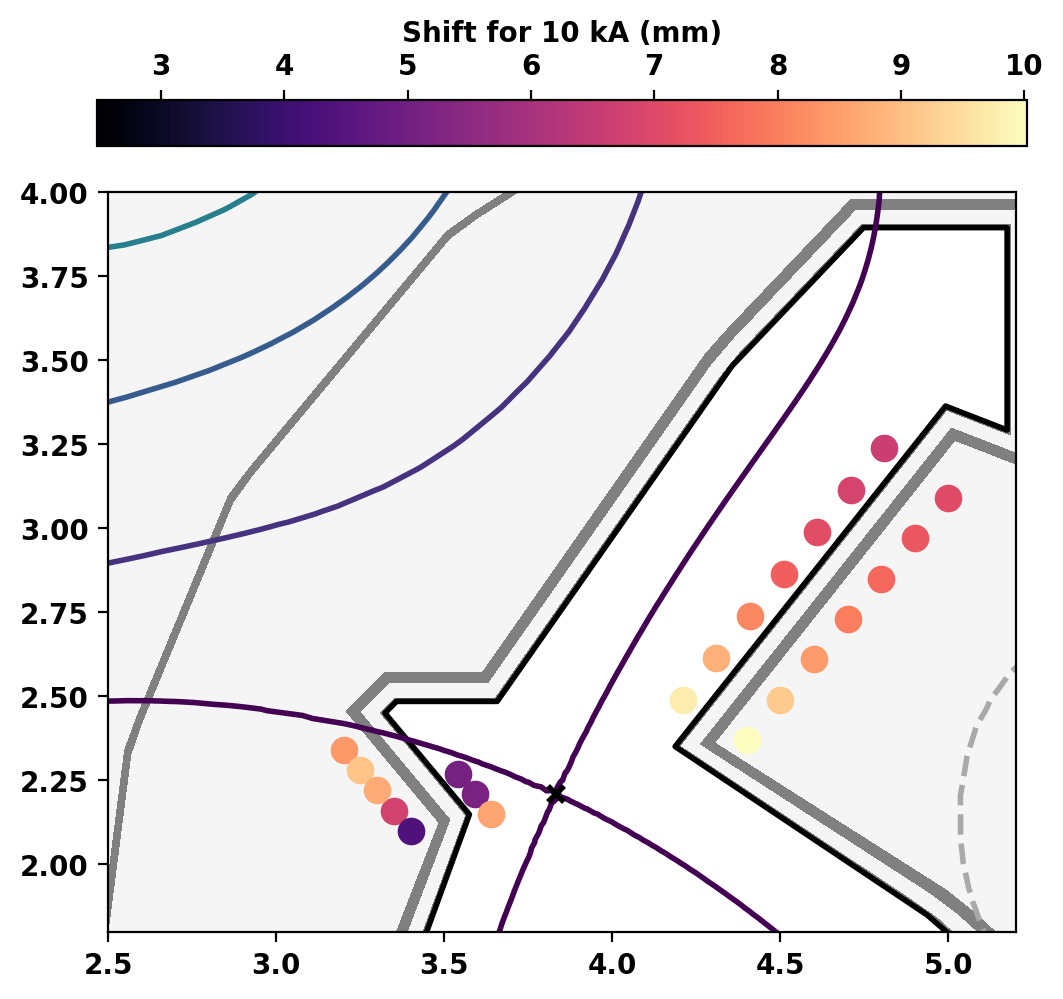

In [23]:
cmap = plt.get_cmap('magma')
left_max = np.max(left)
right_max = np.max(right)

fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax)
mygs.plot_psi(fig,ax)
ax.set_xlim([2.5, 5.2])
ax.set_ylim([1.8,4])

for i,p in enumerate(pts):
    c = cmap(left[i]/left_max)
    ax.scatter(p[0],p[1], c = c, s = 80)

norm = mpl.colors.Normalize(vmin=np.min(left)*1000, vmax=np.max(left)*1000)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation = 'horizontal', location = 'top', label = 'Shift for 10 kA (mm)')

/var/folders/hx/px24dh2d0bv8fs3t0c3v7ymm0000gn/T/ipykernel_56089/3239737548.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(p[0],p[1], c = c, s = 80)


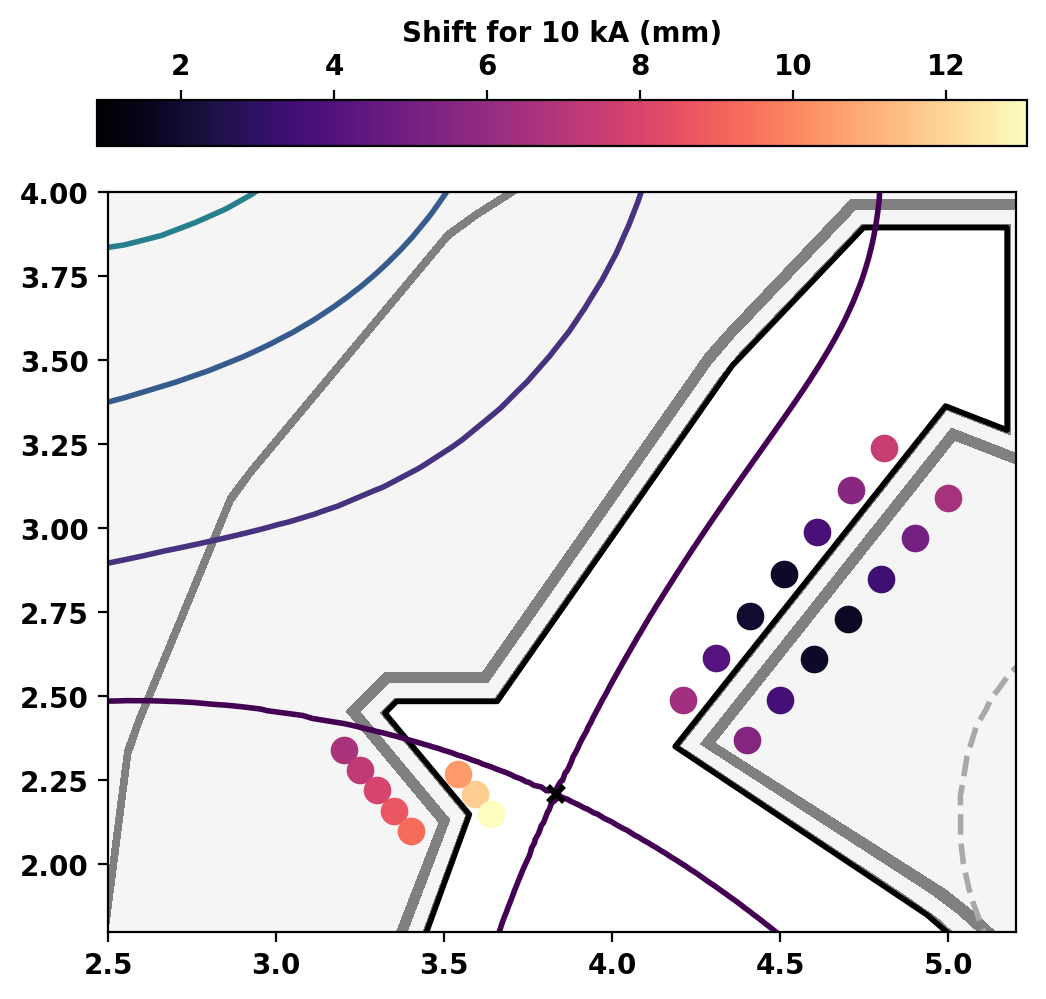

In [22]:
cmap = plt.get_cmap('magma')
left_max = np.max(left)
right_max = np.max(right)

fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax)
mygs.plot_psi(fig,ax)
ax.set_xlim([2.5, 5.2])
ax.set_ylim([1.8,4])

for i,p in enumerate(pts):
    c = cmap(right[i]/right_max)
    ax.scatter(p[0],p[1], c = c, s = 80)

norm = mpl.colors.Normalize(vmin=np.min(right)*1000, vmax=np.max(right)*1000)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation = 'horizontal', location = 'top', label = 'Shift for 10 kA (mm)')